# 1. import libraries

In [ ]:
! pip install segmentation_models_3D
!pip install split-folders
#! pip install python_splitter 
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from sklearn.preprocessing import MinMaxScaler #to scale image pixels
import random
import os
import tensorflow as tf
import keras
import pandas as pd
import segmentation_models_3D as sm
scaler = MinMaxScaler()

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(r"/content/drive/My Drive")

# 2. initial understanding of the dataset

In [ ]:
TRAIN_DATASET_PATH = "/content/drive/My Drive/brats2020/BraTS2020_TrainingData/"

#load single image as numpy array
test_image_flair=nib.load(TRAIN_DATASET_PATH + "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii").get_fdata()   # fdata Extract data as numpy ndarray
print(test_image_flair.max())  # we know that we need scale max=,min=0
print(test_image_flair.shape) # get dimentions of image(height, width, depth)

625.0
(240, 240, 155)


### scaling

In [ ]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(TRAIN_DATASET_PATH + "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii").get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)   #convert it to 1d and then to 3d again

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii").get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii").get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)


# test mask use segmented image
test_mask=nib.load(TRAIN_DATASET_PATH + "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()
test_mask=test_mask.astype(np.uint8)
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


### visualization

In [ ]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 8))
    plt.subplot(231)
    plt.imshow(test_image_flair[:,:,layer], cmap='gray')
    plt.title('Image flair')
    plt.subplot(232)
    plt.imshow(test_image_t1[:,:,layer], cmap='gray')
    plt.title('Image t1')
    plt.subplot(233)
    plt.imshow(test_image_t1ce[:,:,layer], cmap='gray')
    plt.title('Image t1ce')
    plt.subplot(234)
    plt.imshow(test_image_t2[:,:,layer], cmap='gray')
    plt.title('Image t2')
    plt.subplot(235)
    plt.imshow(test_mask[:,:,layer])
    plt.title('Mask')
    plt.show()
    
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

In [ ]:

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0,154)); 

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

### combine three images into only one image using np.stack as we can use it in training model

In [ ]:
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
combined_x.shape #(240, 240, 155, 3) 3 is channel


(240, 240, 155, 3)

### crop useless regions 

In [ ]:
#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

print(combined_x.shape)

(128, 128, 128, 3)


In [ ]:
#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]
print(test_mask.shape)

(128, 128, 128)


In [ ]:
# Define a function to visualize the data
def explore_croped_image(layer):
    plt.figure(figsize=(10, 8))
    plt.subplot(221)
    plt.imshow(combined_x[:,:,layer, 0], cmap='gray')
    plt.title('Image flair')
    plt.subplot(222)
    plt.imshow(combined_x[:,:,layer, 1], cmap='gray')
    plt.title('Image t1ce')
    plt.subplot(223)
    plt.imshow(combined_x[:,:,layer, 2], cmap='gray')
    plt.title('Image t2')
    plt.subplot(224)
    plt.imshow(test_mask[:,:,layer])
    plt.title('Mask')
    plt.show()
    
    plt.title('Explore Layers of Brain MRI croped (ROI)', fontsize=20)
    plt.axis('off')
    return layer

In [ ]:
# Run the ipywidgets interact() function to explore the data
interact(explore_croped_image, layer=(13,127)); 

interactive(children=(IntSlider(value=70, description='layer', max=127, min=13), Output()), _dom_classes=('wid…

In [ ]:
np.save(TRAIN_DATASET_PATH + "combined255.npy", combined_x)
#Verify image is being read properly

my_img=np.load(TRAIN_DATASET_PATH + "combined255.npy")
print(my_img.shape)


(128, 128, 128, 3)


### define number of classes equal four

In [ ]:
test_mask = to_categorical(test_mask, num_classes=4)
print(test_mask.shape)

(128, 128, 128, 4)


## images lists

In [ ]:
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii')) ### it's not informative to us so we wil ignore it 
t2_list = sorted(glob.glob(TRAIN_DATASET_PATH +"MICCAI_BraTS2020_TrainingData/" + "*/*t2.nii"))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH+"MICCAI_BraTS2020_TrainingData/" +"*/*t1ce.nii"))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH+"MICCAI_BraTS2020_TrainingData/" +"*/*flair.nii"))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH+"MICCAI_BraTS2020_TrainingData/" +"*/*seg.nii"))


In [ ]:
t2_list

['/content/drive/My Drive/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii',
 '/content/drive/My Drive/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t2.nii',
 '/content/drive/My Drive/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii',
 '/content/drive/My Drive/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/BraTS20_Training_004_t2.nii',
 '/content/drive/My Drive/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_t2.nii',
 '/content/drive/My Drive/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006/BraTS20_Training_006_t2.nii',
 '/content/drive/My Drive/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_007/BraTS20_Training_007_t2.nii',
 '/content/drive/My 

### scaling loaded images

In [ ]:

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    ## combine loaded image
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    ## calculate values and count of values to calc percentage of labels in the mask 
    val, counts = np.unique(temp_mask, return_counts=True) 


###(if percent<1 it will be ignored )
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(TRAIN_DATASET_PATH+"input_data_3channels/images/image_"+str(img)+'.npy', temp_combined_images)
        np.save(TRAIN_DATASET_PATH+"input_data_3channels/masks/mask_"+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   
   


## split folders into training and validation data

In [ ]:
import splitfolders  # or import split_folders
#import python_splitter
input_folder =  TRAIN_DATASET_PATH+"input_data_3channels/"
output_folder =  TRAIN_DATASET_PATH+"input_data_128/"
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
########################################


Copying files: 0 files [00:00, ? files/s]
Copying files: 2 files [00:00,  8.60 files/s]
Copying files: 3 files [00:00,  6.42 files/s]
Copying files: 4 files [00:00,  5.45 files/s]
Copying files: 5 files [00:00,  5.04 files/s]
Copying files: 6 files [00:01,  4.75 files/s]
Copying files: 7 files [00:02,  2.29 files/s]
Copying files: 8 files [00:05,  1.52s/ files]
Copying files: 9 files [00:08,  1.91s/ files]
Copying files: 10 files [00:09,  1.68s/ files]
Copying files: 11 files [00:18,  3.75s/ files]
Copying files: 12 files [00:20,  3.31s/ files]
Copying files: 13 files [00:21,  2.62s/ files]
Copying files: 14 files [00:23,  2.51s/ files]
Copying files: 15 files [00:26,  2.55s/ files]
Copying files: 16 files [00:29,  2.68s/ files]
Copying files: 17 files [00:33,  3.06s/ files]
Copying files: 18 files [00:36,  3.01s/ files]
Copying files: 19 files [00:37,  2.43s/ files]
Copying files: 20 files [00:40,  2.47s/ files]
Copying files: 21 files [00:42,  2.58s/ files]
Copying files: 22 files [

# 2.Custom data generator

look at list of images and load it in numpy array it doesn't care about any thing else

In [ ]:
def load_img(img_dir, img_list):
    images=[] #empty list of images
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

image loader which will use int it load_img function 
it returns yield of image and mask 

In [ ]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

### Test the generator

In [ ]:
train_img_dir = TRAIN_DATASET_PATH+"input_data_128/train/images/"
train_mask_dir = TRAIN_DATASET_PATH+"input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)


In [ ]:
# Define a function to visualize the data
def explore_image(layer):

    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.imshow(test_img[:,:,layer, 0], cmap='gray')
    plt.title('Image flair')
    plt.subplot(222)
    plt.imshow(test_img[:,:,layer, 1], cmap='gray')
    plt.title('Image t1ce')
    plt.subplot(223)
    plt.imshow(test_img[:,:,layer, 2], cmap='gray')
    plt.title('Image t2')
    plt.subplot(224)
    plt.imshow(test_mask[:,:,layer])
    plt.title('Mask')
    plt.show()
    plt.title('Explore Layers of batches', fontsize=20)
    plt.axis('off')
    return layer

In [ ]:
# Run the ipywidgets interact() function to explore the data
interact(explore_image, layer=(13,127)); 

interactive(children=(IntSlider(value=70, description='layer', max=127, min=13), Output()), _dom_classes=('wid…

# 3. building 3D U_net

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

In [ ]:
kernel_initializer =  'he_uniform'
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model


### Test if everything is working ok. 


In [ ]:
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 12  0           ['conv3d_38[0][0]']              
                                8, 16)                                                      

# 4.training and predection

for the last time make sure that all channels are connected correctly

In [ ]:

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+train_img_list[img_num])
test_mask = np.load(train_mask_dir+train_mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

# Run the ipywidgets interact() function to explore the data
interact(explore_image, layer=(13,127)); 

interactive(children=(IntSlider(value=70, description='layer', max=127, min=13), Output()), _dom_classes=('wid…

In [ ]:
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob(TRAIN_DATASET_PATH+"input_data_128/train/masks/*.npy"))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)
print("label_0",{wt0},"label_1",{wt1},"label_2",{wt2},"label_3",{wt3})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
label_0 {0.25} label_1 {37.96} label_2 {37.96} label_3 {40.98}


label_0 {0.26} label_1 {22.53} label_2 {22.53} label_3 {26.21}
can be used in dice loss

In [ ]:
#Define the image generators for training and validation

train_img_dir = TRAIN_DATASET_PATH+"input_data_128/train/images/"
train_mask_dir = TRAIN_DATASET_PATH+"input_data_128/train/masks/"

val_img_dir = TRAIN_DATASET_PATH+"input_data_128/val/images/"
val_mask_dir = TRAIN_DATASET_PATH+ "input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [ ]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
#Define loss, metrics and optimizer to be used for training
# wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [ ]:
print(metrics)

['accuracy', <segmentation_models_3D.metrics.IOUScore object at 0x7fcfc6638670>]


## fit the model

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_57 (Conv3D)             (None, 128, 128, 12  1312        ['input_4[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_27 (Dropout)           (None, 128, 128, 12  0           ['conv3d_57[0][0]']              
                                8, 16)                                                      

7/7 [==============================] - ETA: 0s - loss: 1.0014 - accuracy: 0.6178 - iou_score: 0.0312

7/7 [==============================] - 13s 2s/step - loss: 1.0014 - accuracy: 0.6178 - iou_score: 0.0312 - val_loss: 0.9833 - val_accuracy: 0.7949 - val_iou_score: 0.0861
Epoch 2/50
7/7 [==============================] - 10s 2s/step - loss: 0.9697 - accuracy: 0.8531 - iou_score: 0.1737 - val_loss: 0.9678 - val_accuracy: 0.9446 - val_iou_score: 0.1636
Epoch 3/50
7/7 [==============================] - 9s 1s/step - loss: 0.9612 - accuracy: 0.9461 - iou_score: 0.2096 - val_loss: 0.9668 - val_accuracy: 0.9492 - val_iou_score: 0.1635
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 0.9564 - accuracy: 0.9535 - iou_score: 0.2215 - val_loss: 0.9660 - val_accuracy: 0.9498 - val_iou_score: 0.1650
Epoch 5/50
7/7 [==============================] - 9s 1s/step - loss: 0.9510 - accuracy: 0.9539 - iou_score: 0.2300 - val_loss: 0.9661 - val_accuracy: 0.9502 - val_iou_score: 0.1503
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 0.9464 - accuracy: 0.9574 - iou_sco

In [ ]:
model.save('brats_3d.hdf5')

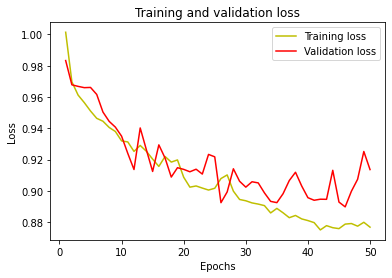

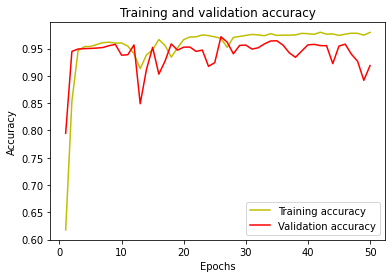

In [ ]:

#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### be sure model is saved

In [ ]:
new_model = load_model('brats_3d.hdf5',compile=False)

# Show the model architecture
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_57 (Conv3D)             (None, 128, 128, 12  1312        ['input_4[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_27 (Dropout)           (None, 128, 128, 12  0           ['conv3d_57[0][0]']              
                                8, 16)                                                      

In [ ]:
from keras.models import load_model

#Load model for prediction 
my_model = load_model("brats_3d.hdf5",compile=False)

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
my_model = load_model("brats_3d.hdf5",compile=False, 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
my_model = load_model("brats_3d.hdf5",compile=False,
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

my_model.compile(optimizer="adam", loss=total_loss)

#Now all set to continue the training process. 
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


7/7 [==============================] - 11s 1s/step - loss: 0.9670 - val_loss: 0.9861


In [ ]:
#For predictions you do not need to compile the model, so ...
my_model = load_model("brats_3d.hdf5",compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=2 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 [==============================] - 0s 321ms/step
Mean IoU = 0.37068385


In [ ]:
#Predict on a few test images, one at a time
#Try images: 
img_num = 16

test_img = np.load(TRAIN_DATASET_PATH+"input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load(TRAIN_DATASET_PATH+"input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 0s 104ms/step


In [ ]:
# Define a function to visualize the data
def explore_predicted_image(layer):
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,layer,1], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(test_mask_argmax[:,:,layer])
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction_argmax[:,:, layer])
  plt.show()
  plt.axis('off')
  return layer

In [ ]:
interact(explore_predicted_image, layer=(13,127)); 

interactive(children=(IntSlider(value=70, description='layer', max=127, min=13), Output()), _dom_classes=('wid…